In [1]:
# step 3
from nilearn import datasets
from nilearn import image, plotting
from nilearn.input_data import NiftiLabelsMasker
from alive_progress import alive_bar
from tqdm import tqdm
import nibabel as nib
import pandas as pd
import numpy as np
#from hm_tools import *
import scipy.io 
import h5py
import mne
import sys
import os
from glob import glob
sys.path.insert(0, 'E:/workspace/my_py_toolbox/')
from hm_tools import *

data_path = "E:/workspace/OTface/roi_data/aal_smooth6/"
result_path = "E:/workspace/OTface/roi_data/aal_smooth6/cpm/"
condition_name = ['OT', 'PL']
file_name = ['task', 'rest']

# mapping from subject id to group
sub2group = dict()
[sub2group.update({f"s{path[-3:]}": group}) for group in ["OT", "PL"] for path in glob(os.path.join(data_path, "task", "preprocess", group, "sub*"))]
print(sub2group)


{}


In [ ]:
hm_shutdown(1800)

In [2]:
# 90 aal rois
roi_name = np.array(['Precentral_L','Precentral_R',
 'Frontal_Sup_L', 'Frontal_Sup_R',
 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R',
 'Frontal_Mid_L', 'Frontal_Mid_R',
 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R',
 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R',
 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R',
 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R',
 'Rolandic_Oper_L', 'Rolandic_Oper_R',
 'Supp_Motor_Area_L', 'Supp_Motor_Area_R',
 'Olfactory_L', 'Olfactory_R',
 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R',
 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R',
 'Rectus_L', 'Rectus_R',
 'Insula_L', 'Insula_R',
 'Cingulum_Ant_L', 'Cingulum_Ant_R',
 'Cingulum_Mid_L', 'Cingulum_Mid_R',
 'Cingulum_Post_L', 'Cingulum_Post_R',
 'Hippocampus_L', 'Hippocampus_R',
 'ParaHippocampal_L', 'ParaHippocampal_R',
 'Amygdala_L', 'Amygdala_R',
 'Calcarine_L', 'Calcarine_R',
 'Cuneus_L', 'Cuneus_R',
 'Lingual_L', 'Lingual_R',
 'Occipital_Sup_L', 'Occipital_Sup_R',
 'Occipital_Mid_L', 'Occipital_Mid_R',
 'Occipital_Inf_L', 'Occipital_Inf_R',
 'Fusiform_L', 'Fusiform_R',
 'Postcentral_L', 'Postcentral_R',
 'Parietal_Sup_L', 'Parietal_Sup_R',
 'Parietal_Inf_L', 'Parietal_Inf_R',
 'SupraMarginal_L', 'SupraMarginal_R',
 'Angular_L', 'Angular_R',
 'Precuneus_L', 'Precuneus_R',
 'Paracentral_Lobule_L', 'Paracentral_Lobule_R',
 'Caudate_L', 'Caudate_R',
 'Putamen_L', 'Putamen_R',
 'Pallidum_L', 'Pallidum_R',
 'Thalamus_L', 'Thalamus_R',
 'Heschl_L', 'Heschl_R',
 'Temporal_Sup_L', 'Temporal_Sup_R',
 'Temporal_Pole_Sup_L', 'Temporal_Pole_Sup_R',
 'Temporal_Mid_L', 'Temporal_Mid_R',
 'Temporal_Pole_Mid_L', 'Temporal_Pole_Mid_R',
 'Temporal_Inf_L', 'Temporal_Inf_R',])

atlas = datasets.fetch_atlas_aal()
print('Power atlas comes with {0}.'.format(atlas.keys()))
all_location = []
for iter_roi_name in roi_name:
    location = np.where(np.array(atlas['labels']) == iter_roi_name)[0][0]
    all_location.append(location)

all_location = np.array(all_location)
print(all_location)

Power atlas comes with dict_keys(['description', 'maps', 'labels', 'indices']).
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]


In [3]:
# 得到rest和task时的功能连接，并且只留下半矩阵并且铺平
filename = ['task', 'rest']
all_data = {}
for iter_file in filename:

    iter_file_data = {}

    fmri_data = np.load(data_path + iter_file + '.npy', allow_pickle=True).item()  # subjects * time * aal rois

    for iter_condition in condition_name:

        iter_condition_coor_matrix = []
        for iter_subject in (range(len(fmri_data[iter_condition]))):
            # 数据维度为 times * 28 ROI
            iter_subjectfmri_data = np.array(fmri_data[iter_condition])[iter_subject, all_location]
            # 把数据维度转换为 ROI * times
            iter_subjectfmri_data = np.transpose(iter_subjectfmri_data)


            iter_data = iter_subjectfmri_data[all_location]
            # ROI两两相关
            iter_coor_matrix = np.corrcoef(iter_data)
            # 去除对角线
            # skip_diag_matrix = skip_diag_masking(iter_coor_matrix)
            # 选取六个ifg区域
            # iter_ifg_matrix = skip_diag_matrix[ifg_location]
            iter_coor_matrix = np.tril(iter_coor_matrix, k=-1)
            iter_coor_matrix = iter_coor_matrix.flatten()
            iter_coor_matrix = iter_coor_matrix[iter_coor_matrix!=0]

            iter_condition_coor_matrix.append(iter_coor_matrix)

        iter_condition_coor_matrix = np.array(iter_condition_coor_matrix)
        iter_file_data[iter_condition] = iter_condition_coor_matrix
    all_data[iter_file] = iter_file_data
all_data['roi_name'] = roi_name

print(np.array(all_data['task']['OT']).shape)
print(np.array(all_data['rest']['PL']).shape)
all_data['rest'] = np.vstack((all_data['rest']['OT'], all_data['rest']['PL']))
all_data['task'] = np.vstack((all_data['task']['OT'], all_data['task']['PL']))
print(np.array(all_data['rest']).shape)
# 找到每个边的命名，并且只取下半部分
all_fc_name = []
for iter_x_location in roi_name:
    iter_x = []
    for iter_y_location in roi_name:
        name = iter_x_location+ '_'+iter_y_location
        iter_x.append(name)
    all_fc_name.append(iter_x)
all_fc_name = np.array(all_fc_name)
all_fc_name = np.tril(all_fc_name, k=-1)
all_fc_name = all_fc_name.flatten()
all_fc_name = all_fc_name[all_fc_name!='']
print(all_fc_name.shape)
#储存
all_data['all_fc_name'] = all_fc_name

# hm_make_dir(result_path)
# np.save(result_path + '/' + 'aal_90roi_fc.npy', all_data)

(30, 4005)
(29, 4005)
(59, 4005)
(4005,)


In [4]:
# Select significant sides (rest)
# create label
from statsmodels.discrete.discrete_model import Logit, Probit, MNLogit
import statsmodels.api as sm
from tqdm import trange
# all_data['rest'] = np.vstack((all_data['rest']['OT'], all_data['rest']['OT']))
# all_data['task'] = np.vstack((all_data['task']['OT'], all_data['task']['OT']))
# print()
selected_feature = {}
selected_feature['rest'] = {}
selected_feature['task'] = {}
# 创建标签
label = np.hstack((np.ones((1, 30)), np.zeros((1, 29))))
label = np.squeeze(label)
# for rest
all_significant_num = []
for iter_fc in trange(all_data['rest'].shape[1]):
    # 提取输入数据
    x = all_data['rest'][:,iter_fc]
    x = sm.add_constant(x)
    
    logit = Logit(np.squeeze(label), x)
    result=logit.fit()
    if result.pvalues[1] < 0.02:
        all_significant_num.append(iter_fc)
    # 
selected_feature['rest']['feature'] = all_data['rest'][:, np.array(all_significant_num)]
selected_feature['rest']['feature_name'] = all_fc_name[np.array(all_significant_num)]


  1%|          | 47/4005 [00:00<00:08, 457.50it/s]

Optimization terminated successfully.
         Current function value: 0.690819
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690354
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692413
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689315
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692311
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.669262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686612
  

  4%|▍         | 162/4005 [00:00<00:07, 535.37it/s]

Optimization terminated successfully.
         Current function value: 0.686850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692850
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692687
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686198
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692696
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688332
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691452
  

  8%|▊         | 305/4005 [00:00<00:05, 641.79it/s]

Optimization terminated successfully.
         Current function value: 0.692931
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687022
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691775
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692147
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.653853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.661583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.660708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.661067
  

 11%|█         | 448/4005 [00:00<00:05, 678.78it/s]

Optimization terminated successfully.
         Current function value: 0.692929
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691151
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687337
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692509
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692954
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680702
  

 15%|█▍        | 591/4005 [00:00<00:04, 695.67it/s]


         Current function value: 0.674291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689795
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.657086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.667643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681130
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690896
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.665531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691092
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692885
         Iterations 3
Optimization term

 18%|█▊        | 739/4005 [00:01<00:04, 714.08it/s]

Optimization terminated successfully.
         Current function value: 0.692823
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690112
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692582
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692119
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691699
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692733
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692421
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688431
  

 20%|██        | 811/4005 [00:01<00:04, 699.56it/s]


         Current function value: 0.667227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.659826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680260
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668453
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688238
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692399
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674860
         Iterations 4
Optimization term

 24%|██▎       | 951/4005 [00:01<00:04, 675.14it/s]

Optimization terminated successfully.
         Current function value: 0.691599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692976
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690571
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682877
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692534
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689655
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689154
  

 27%|██▋       | 1089/4005 [00:01<00:04, 678.98it/s]

Optimization terminated successfully.
         Current function value: 0.689586
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671527
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689989
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685866
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692040
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692998
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687685
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684017
  

 31%|███       | 1231/4005 [00:01<00:04, 691.15it/s]

Optimization terminated successfully.
         Current function value: 0.686807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.667078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.659955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.667211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689534
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673273
  

 34%|███▍      | 1370/4005 [00:02<00:03, 677.27it/s]

Optimization terminated successfully.
         Current function value: 0.686863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687081
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679315
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677835
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.658553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.666387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652063
  

 36%|███▌      | 1441/4005 [00:02<00:03, 685.43it/s]

Optimization terminated successfully.
         Current function value: 0.682416
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680712
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692499
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689904
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692146
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.662440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.669511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683256
  

 40%|███▉      | 1583/4005 [00:02<00:03, 694.16it/s]

Optimization terminated successfully.
         Current function value: 0.676402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679584
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.664447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679564
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685068
  

 43%|████▎     | 1731/4005 [00:02<00:03, 711.72it/s]

Optimization terminated successfully.
         Current function value: 0.681606
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691962
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685048
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684270
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676482
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679321
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680386
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685989
  

 47%|████▋     | 1876/4005 [00:02<00:03, 707.46it/s]

Optimization terminated successfully.
         Current function value: 0.692904
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692604
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689621
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692849
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692968
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692481
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684112
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692847
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689165
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691529
  

 50%|█████     | 2022/4005 [00:02<00:02, 709.65it/s]

Optimization terminated successfully.
         Current function value: 0.690459
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684754
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691609
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685992
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692541
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691945
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692982
  

 52%|█████▏    | 2093/4005 [00:03<00:02, 695.98it/s]

Optimization terminated successfully.
         Current function value: 0.685253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692396
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678903
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671515
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.654658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.675480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687134
  

 56%|█████▌    | 2233/4005 [00:03<00:02, 688.39it/s]

Optimization terminated successfully.
         Current function value: 0.691953
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.673229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688372
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680626
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692625
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692917
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693004
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692404
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692556
  

 59%|█████▉    | 2370/4005 [00:03<00:02, 644.41it/s]

Optimization terminated successfully.
         Current function value: 0.686246
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692749
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692921
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692720
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692875
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687145
  

 62%|██████▏   | 2499/4005 [00:03<00:02, 624.26it/s]

Optimization terminated successfully.
         Current function value: 0.676937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.675369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684980
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692798
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692045
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693003
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692995
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691266
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691778
  

 64%|██████▍   | 2562/4005 [00:03<00:02, 602.36it/s]

Optimization terminated successfully.
         Current function value: 0.669788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.675696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677692
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.663657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.673167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688442
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672668
  

 67%|██████▋   | 2686/4005 [00:04<00:02, 603.12it/s]

Optimization terminated successfully.
         Current function value: 0.691571
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677922
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683106
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692916
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692878
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692470
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692569
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.671890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690666
  

 70%|███████   | 2817/4005 [00:04<00:01, 624.37it/s]


         Current function value: 0.682175
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666211
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680446
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691550
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678775
         Iterations 4
Optimization term

 74%|███████▍  | 2963/4005 [00:04<00:01, 671.17it/s]

Optimization terminated successfully.
         Current function value: 0.681303
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692446
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691563
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671554
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685413
  

 78%|███████▊  | 3104/4005 [00:04<00:01, 649.89it/s]

Optimization terminated successfully.
         Current function value: 0.690470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692127
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692953
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679224
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685831
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692854
  

 81%|████████  | 3237/4005 [00:04<00:01, 653.53it/s]

Optimization terminated successfully.
         Current function value: 0.692600
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692365
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692992
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688403
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677182
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682998
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684057
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668609
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692443
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692942
  

 82%|████████▏ | 3303/4005 [00:04<00:01, 653.98it/s]

Optimization terminated successfully.
         Current function value: 0.692950
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692424
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692366
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693003
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692969
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691211
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688284
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692735
  

 86%|████████▌ | 3433/4005 [00:05<00:00, 601.40it/s]

Optimization terminated successfully.
         Current function value: 0.678664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689216
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692080
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690794
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692310
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692467
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692888
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.675120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.665102
  

 89%|████████▉ | 3566/4005 [00:05<00:00, 627.32it/s]

Optimization terminated successfully.
         Current function value: 0.678570
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682091
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685434
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672772
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682626
  

 93%|█████████▎| 3714/4005 [00:05<00:00, 683.37it/s]

Optimization terminated successfully.
         Current function value: 0.682556
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692922
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692411
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683946
  

 94%|█████████▍| 3783/4005 [00:05<00:00, 679.88it/s]

Optimization terminated successfully.
         Current function value: 0.684925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.665741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692959
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692115
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692885
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692211
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680719
  

 98%|█████████▊| 3929/4005 [00:05<00:00, 704.24it/s]

Optimization terminated successfully.
         Current function value: 0.667253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682404
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683183
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675825
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.654825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664038
  

100%|██████████| 4005/4005 [00:06<00:00, 664.69it/s]

Optimization terminated successfully.
         Current function value: 0.691739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686315
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692249
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693000
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683714
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682814
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672372
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.652341
  

In [ ]:
print(selected_feature['rest']['feature_name'].shape)

In [5]:
# Select significant sides (task)
all_significant_num = []
for iter_fc in trange(all_data['task'].shape[1]):
    # 提取输入数据
    x = all_data['task'][:,iter_fc]
    x = sm.add_constant(x)
    
    logit = Logit(np.squeeze(label), x)
    result=logit.fit()
    if result.pvalues[1] < 0.05:
        all_significant_num.append(iter_fc)
    # 
selected_feature['task']['feature'] = all_data['task'][:, np.array(all_significant_num)]
selected_feature['task']['feature_name'] = all_fc_name[np.array(all_significant_num)]
print(all_fc_name[np.array(all_significant_num)])

  2%|▏         | 67/4005 [00:00<00:05, 665.14it/s]

Optimization terminated successfully.
         Current function value: 0.688413
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684956
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688729
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692876
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683529
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689412
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689249
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.663633
  

  5%|▌         | 213/4005 [00:00<00:05, 710.49it/s]

Optimization terminated successfully.
         Current function value: 0.689481
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692028
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692981
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692995
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691684
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692501
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689532
  

  7%|▋         | 285/4005 [00:00<00:05, 680.33it/s]

Optimization terminated successfully.
         Current function value: 0.683204
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687892
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690224
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691520
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692370
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687277
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690203
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688424
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692985
  

  9%|▉         | 358/4005 [00:00<00:05, 697.12it/s]

Optimization terminated successfully.
         Current function value: 0.685627
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689596
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690556
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689841
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685831
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686008
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682101
  

 11%|█         | 436/4005 [00:00<00:04, 720.50it/s]

Optimization terminated successfully.
         Current function value: 0.681789
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684745
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692797
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680684
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670337
  

 13%|█▎        | 514/4005 [00:00<00:04, 737.84it/s]

Optimization terminated successfully.
         Current function value: 0.692903
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680859
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692928
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690875
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692810
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692680
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692756
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691826
  

 15%|█▍        | 589/4005 [00:00<00:04, 739.95it/s]

Optimization terminated successfully.
         Current function value: 0.691869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692989
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692997
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690277
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691157
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692968
  

 17%|█▋        | 665/4005 [00:00<00:04, 744.47it/s]

Optimization terminated successfully.
         Current function value: 0.684237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.661312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.668152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690406
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687989
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692955
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689079
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688958
  

 19%|█▊        | 743/4005 [00:01<00:04, 752.74it/s]

Optimization terminated successfully.
         Current function value: 0.692873
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687338
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685981
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690455
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692743
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689723
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682936
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692930
  

 22%|██▏       | 900/4005 [00:01<00:04, 766.13it/s]

Optimization terminated successfully.
         Current function value: 0.680341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692109
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692861
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691206
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688871
  

 24%|██▍       | 977/4005 [00:01<00:04, 749.97it/s]

Optimization terminated successfully.
         Current function value: 0.687612
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692330
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688186
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.678580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684740
  

 26%|██▋       | 1053/4005 [00:01<00:03, 742.58it/s]

Optimization terminated successfully.
         Current function value: 0.676185
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692548
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692916
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692992
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.672024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670270
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691190
  

 28%|██▊       | 1128/4005 [00:01<00:03, 730.35it/s]

Optimization terminated successfully.
         Current function value: 0.686727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692892
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686207
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679782
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692492
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689798
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691557
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691379
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675368
  

 30%|███       | 1202/4005 [00:01<00:03, 723.20it/s]

Optimization terminated successfully.
         Current function value: 0.690569
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692961
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692991
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688081
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692688
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690386
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692681
  

 32%|███▏      | 1275/4005 [00:01<00:03, 717.40it/s]

Optimization terminated successfully.
         Current function value: 0.692063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685224
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692934
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692468
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691732
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689515
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691626
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685725
  

 34%|███▎      | 1349/4005 [00:01<00:03, 722.46it/s]

Optimization terminated successfully.
         Current function value: 0.681157
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691926
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690425
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692433
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692992
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691740
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688461
  

 36%|███▌      | 1427/4005 [00:01<00:03, 737.77it/s]

Optimization terminated successfully.
         Current function value: 0.692206
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692785
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692993
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692534
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693004
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692789
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692994
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692024
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692747
  

 38%|███▊      | 1502/4005 [00:02<00:03, 739.99it/s]

Optimization terminated successfully.
         Current function value: 0.691337
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690711
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691133
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692454
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692745
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692779
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692033
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692568
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684259
  

 40%|███▉      | 1582/4005 [00:02<00:03, 753.56it/s]

Optimization terminated successfully.
         Current function value: 0.688396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692774
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691424
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688213
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692746
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692997
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692643
  

 43%|████▎     | 1733/4005 [00:02<00:03, 748.00it/s]

Optimization terminated successfully.
         Current function value: 0.688754
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.669683
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.662264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.678653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.663991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680406
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690343
  

 45%|████▌     | 1808/4005 [00:02<00:03, 708.38it/s]

Optimization terminated successfully.
         Current function value: 0.687752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692998
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685973
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689472
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677289
  

 47%|████▋     | 1881/4005 [00:02<00:02, 713.07it/s]

Optimization terminated successfully.
         Current function value: 0.690425
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672050
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692999
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692961
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693002
  

 49%|████▉     | 1958/4005 [00:02<00:02, 728.02it/s]

Optimization terminated successfully.
         Current function value: 0.675953
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686423
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681905
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692549
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.671581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692613
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693003
  

 51%|█████     | 2036/4005 [00:02<00:02, 741.63it/s]

Optimization terminated successfully.
         Current function value: 0.692997
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689730
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683499
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687336
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692436
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693003
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683934
  

 53%|█████▎    | 2116/4005 [00:02<00:02, 757.17it/s]

Optimization terminated successfully.
         Current function value: 0.690980
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692319
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691300
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692151
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693000
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689926
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691061
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688104
  

 55%|█████▍    | 2193/4005 [00:02<00:02, 760.89it/s]

Optimization terminated successfully.
         Current function value: 0.688730
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690412
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683327
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683425
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.662349
  

 57%|█████▋    | 2270/4005 [00:03<00:02, 759.69it/s]

Optimization terminated successfully.
         Current function value: 0.687073
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684100
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682934
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693001
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687839
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692601
  

 60%|██████    | 2421/4005 [00:03<00:02, 721.00it/s]

Optimization terminated successfully.
         Current function value: 0.691590
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692997
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692717
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685000
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683143
  

 62%|██████▏   | 2494/4005 [00:03<00:02, 709.84it/s]

Optimization terminated successfully.
         Current function value: 0.692962
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692795
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693000
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680283
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.663194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692806
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677271
  

 64%|██████▍   | 2566/4005 [00:03<00:02, 698.63it/s]

Optimization terminated successfully.
         Current function value: 0.665278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688958
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692432
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691181
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688590
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692921
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692804
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690454
  

 66%|██████▌   | 2636/4005 [00:03<00:02, 670.71it/s]

Optimization terminated successfully.
         Current function value: 0.683223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684668
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688577
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685361
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689150
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676489
  

 68%|██████▊   | 2704/4005 [00:03<00:01, 670.57it/s]

Optimization terminated successfully.
         Current function value: 0.682710
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687372
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692987
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690685
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692637
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677138
  

 69%|██████▉   | 2772/4005 [00:03<00:01, 649.61it/s]

Optimization terminated successfully.
         Current function value: 0.692184
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689166
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691252
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692696
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692691
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692842
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692994
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692995
  

 71%|███████   | 2838/4005 [00:03<00:01, 626.48it/s]

Optimization terminated successfully.
         Current function value: 0.690063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692941
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687812
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690729
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690787
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692744
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681851
  

 72%|███████▏  | 2903/4005 [00:04<00:01, 630.02it/s]

Optimization terminated successfully.
         Current function value: 0.689888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692111
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683089
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690383
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687265
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692827
  

 74%|███████▍  | 2970/4005 [00:04<00:01, 638.47it/s]

Optimization terminated successfully.
         Current function value: 0.674848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.667956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688090
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686866
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675953
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674356
  

 76%|███████▌  | 3037/4005 [00:04<00:01, 646.20it/s]

Optimization terminated successfully.
         Current function value: 0.691529
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692368
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692904
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692964
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692986
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692994
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692754
  

 78%|███████▊  | 3106/4005 [00:04<00:01, 657.55it/s]

Optimization terminated successfully.
         Current function value: 0.692359
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692262
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690971
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691870
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692820
  

 79%|███████▉  | 3174/4005 [00:04<00:01, 660.79it/s]

Optimization terminated successfully.
         Current function value: 0.685952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692783
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683160
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690778
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686586
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687411
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683539
  

 81%|████████  | 3248/4005 [00:04<00:01, 680.63it/s]


Optimization terminated successfully.
         Current function value: 0.692376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692978
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692119
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692560
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679577
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688998
 

 83%|████████▎ | 3317/4005 [00:04<00:01, 662.48it/s]

Optimization terminated successfully.
         Current function value: 0.691524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692861
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692475
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692432
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684125
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689087
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685151
  

 85%|████████▍ | 3391/4005 [00:04<00:00, 681.54it/s]

Optimization terminated successfully.
         Current function value: 0.677728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676861
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687525
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692895
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684459
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682881
  

 88%|████████▊ | 3539/4005 [00:04<00:00, 709.53it/s]

Optimization terminated successfully.
         Current function value: 0.692987
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692898
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688525
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678479
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683556
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663144
  

 90%|█████████ | 3611/4005 [00:05<00:00, 709.01it/s]

Optimization terminated successfully.
         Current function value: 0.685632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683669
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690906
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692995
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677518
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692951
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690586
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686101
  

 92%|█████████▏| 3687/4005 [00:05<00:00, 720.91it/s]

Optimization terminated successfully.
         Current function value: 0.692993
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692580
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688343
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691806
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692949
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691217
  

 94%|█████████▍| 3761/4005 [00:05<00:00, 725.00it/s]

Optimization terminated successfully.
         Current function value: 0.692971
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692890
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688932
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687626
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685480
  

 96%|█████████▌| 3835/4005 [00:05<00:00, 725.73it/s]

Optimization terminated successfully.
         Current function value: 0.680957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.672601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682250
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692420
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692700
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692954
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691808
  

 98%|█████████▊| 3908/4005 [00:05<00:00, 719.06it/s]

Optimization terminated successfully.
         Current function value: 0.692882
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692913
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681413
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689144
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692990
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692847
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692077
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692133
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692998
  

 99%|█████████▉| 3980/4005 [00:05<00:00, 709.44it/s]

Optimization terminated successfully.
         Current function value: 0.681527
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683848
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690971
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692766
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692223
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691439
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689352
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692997
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691374
  

100%|██████████| 4005/4005 [00:05<00:00, 710.86it/s]

Optimization terminated successfully.
         Current function value: 0.691896
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692375
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693004
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692692
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692822
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691328
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685723
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682110
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683767
         Iterations 4
['Rectus_R_Frontal_Inf_Tri_L' 'Insula_R_Frontal_Sup_Orb_L'
 'Cuneus_R_Hippocampus_

In [6]:
print(all_fc_name[np.array(all_significant_num)].shape)

(42,)


In [40]:
hm_make_dir(result_path)
np.save(result_path + '/' + 'task_selected_feature_90roi_p02.npy', selected_feature)

In [ ]:
# print(selected_feature['task']['feature_name'].shape)
print(selected_feature['rest']['feature_name'].shape)

In [37]:
#进行单次svm
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier

import scipy.io as scio  # 用于读取matlab格式的数据
import copy
from sklearn.metrics import accuracy_score

scaler = StandardScaler()

# import data
dataset = scaler.fit_transform(selected_feature['task']['feature'])
# dataset = selected_feature['rest']['feature']    
############################SVM+LOOVC################
loo = LeaveOneOut()
loo.get_n_splits(dataset)
predictlabel_list = []
reallabel_list = []

# C：C-SVC的惩罚参数C
# kernel: linear, poly, rbf, sigmoid, precomputed
C = 1
clf = SVC(C=C, kernel='linear', gamma='auto', degree=6 )
# clf = XGBClassifier()
# 用留一法进行验证
for train_index, test_index in loo.split(dataset):
    # 分割训练集
    X_train, X_test = dataset[train_index], dataset[test_index]
    # 分割测试集
    Y_train, Y_test = label[np.array(train_index)], label[np.array(test_index)]
    # 拟合
    clf.fit(X_train, Y_train)
    # 储存训练结果
    predictlabel_list.append(list(clf.predict(X_test)))
    reallabel_list.append(list(Y_test))

# accurancy = count_right_label / len(label)
accuracy = accuracy_score(reallabel_list,predictlabel_list)
print('******循环结束！************')
print('准确率为：%.2f%%' % (accuracy * 100))
print('******运行结束！************')

******循环结束！************
准确率为：66.10%
******运行结束！************


In [ ]:
#进行单次svm
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import scipy.io as scio  # 用于读取matlab格式的数据
import copy
from xgboost import XGBRFClassifier
from sklearn.metrics import accuracy_score

scaler = StandardScaler()

# import data
dataset = scaler.fit_transform(selected_feature['rest']['feature'])
# dataset = selected_feature['rest']['feature']    
############################SVM+LOOVC################
loo = LeaveOneOut()
loo.get_n_splits(dataset)
predictlabel_list = []
reallabel_list = []

# C：C-SVC的惩罚参数C
# kernel: linear, poly, rbf, sigmoid, precomputed
model = XGBRFClassifier()

# 用留一法进行验证
for train_index, test_index in loo.split(dataset):
    # 分割训练集
    X_train, X_test = dataset[train_index], dataset[test_index]
    # 分割测试集
    Y_train, Y_test = label[np.array(train_index)], label[np.array(test_index)]
    # 拟合
    model.fit(X_train, Y_train)
    # 储存训练结果
    predictlabel_list.append(list(model.predict(X_test)))
    reallabel_list.append(list(Y_test))

# accurancy = count_right_label / len(label)
accuracy = accuracy_score(reallabel_list,predictlabel_list)
print('******循环结束！************')
print('准确率为：%.2f%%' % (accuracy * 100))
print('******运行结束！************')

In [9]:
#进行单次xgboost
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import scipy.io as scio  # 用于读取matlab格式的数据
import copy
from sklearn.metrics import accuracy_score

scaler = StandardScaler()

# import data
dataset = scaler.fit_transform(selected_feature['task']['feature'])
# dataset = selected_feature['rest']['feature']    
############################SVM+LOOVC################
loo = LeaveOneOut()
loo.get_n_splits(dataset)
predictlabel_list = []
reallabel_list = []

# C：C-SVC的惩罚参数C
# kernel: linear, poly, rbf, sigmoid, precomputed
C = 1
clf = SVC(C=C, kernel='linear', gamma='auto', degree=6 )

# 用留一法进行验证
for train_index, test_index in loo.split(dataset):
    # 分割训练集
    X_train, X_test = dataset[train_index], dataset[test_index]
    # 分割测试集
    Y_train, Y_test = label[np.array(train_index)], label[np.array(test_index)]
    # 拟合
    clf.fit(X_train, Y_train)
    # 储存训练结果
    predictlabel_list.append(list(clf.predict(X_test)))
    reallabel_list.append(list(Y_test))

# accurancy = count_right_label / len(label)
accuracy = accuracy_score(reallabel_list,predictlabel_list)
print('******循环结束！************')
print('准确率为：%.2f%%' % (accuracy * 100))
print('******运行结束！************')

******循环结束！************
准确率为：66.10%
******运行结束！************


In [ ]:
Y_train.shape

In [ ]:
#进行permutation xgboost
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
import scipy.io as scio  # 用于读取matlab格式的数据
import copy
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Lasso, ElasticNet

scaler = StandardScaler()

# import data
dataset = scaler.fit_transform(selected_feature['task']['feature'])
# dataset = dataset[:,sorted_index[-10:]]
# dataset = selected_feature['rest']['feature']    
############################SVM+LOOVC################
loo = LeaveOneOut()
loo.get_n_splits(dataset)
predictlabel_list = []
reallabel_list = []

# C：C-SVC的惩罚参数C
# kernel: linear, poly, rbf, sigmoid, precomputed
# del xgb1
# xgb1 = XGBClassifier()
clf = SVC(C=C, kernel='rbf', gamma='auto', degree=6 )
for train_index, test_index in loo.split(dataset):
    # 分割训练集
    X_train, X_test = dataset[train_index], dataset[test_index]
    # 分割测试集
    Y_train, Y_test = label[np.array(train_index)], label[np.array(test_index)]
    # 拟合
    clf.fit(X_train, Y_train)
    # 储存训练结果
    predictlabel_list.append(list(clf.predict(X_test)))
    reallabel_list.append(list(Y_test))


accuracy = accuracy_score(reallabel_list,predictlabel_list)
print('******循环结束！************')
print('准确率为：%.2f%%' % (accuracy * 100))
print('******运行结束！************')

############################Permutation################
n_permutation = 10000

all_permutation_acc = []
for iter_n in trange(n_permutation):
    # label permutation
    iter_label = label.copy()
    iter_label = np.random.permutation(iter_label)
    ############################SVM+LOOVC################
    loo = LeaveOneOut()
    loo.get_n_splits(selected_feature['task']['feature'])
    predictlabel_list = []
    reallabel_list = []

    # 用留一法进行验证
    for train_index, test_index in loo.split(dataset):
        # 分割训练集
        X_train, X_test = dataset[train_index], dataset[test_index]
        # 分割测试集
        Y_train, Y_test = iter_label[np.array(train_index)], iter_label[np.array(test_index)]
        # 拟合
        clf.fit(X_train, Y_train)
        # 储存训练结果
        predictlabel_list.append(list(clf.predict(X_test)))
        reallabel_list.append(list(Y_test))

    iter_accuracy = accuracy_score(reallabel_list,predictlabel_list)
    all_permutation_acc.append(iter_accuracy)


In [ ]:
np.save(result_path + '/' + 'all_permutation_acc_01.npy', all_permutation_acc)

In [ ]:
p_value

In [ ]:
# all_permutation_acc = np.load(result_path + '/' + 'all_permutation_acc_02.npy')
accuracy = 0.5763
import seaborn as sns
import matplotlib.pyplot as plt
bins_interval= 1/59
bins =np.arange(min(all_permutation_acc) - bins_interval/2, max(all_permutation_acc)+bins_interval/2, bins_interval)
# bins = int((max(all_permutation_acc) - min(all_permutation_acc))/bins_interval)+1
p_value = sum(ms > (accuracy) for ms in all_permutation_acc) / len(all_permutation_acc)

plt.figure(figsize=(4.5,3),dpi=100)
ax=plt.gca()
# ax.spines['right'].set_color('none')
# ax.spines['top'].set_color('none')
# sns.kdeplot(all_permutation_acc, shade=True, color='salmon')
# plt.hist(all_permutation_acc, color='salmon', bins = bins)
sns.distplot(all_permutation_acc, bins=bins, color='coral',hist_kws={'rwidth': 0.7})   # kdeplot
# plt.title('rbf 02 10k C = '+ str(C) + ',P = ' + str(p_value))
plt.xlabel('acc')
# plt.xlim()
plt.axvline(accuracy, c="dodgerblue", ls = "dashed")

In [10]:
#每个特征都删一次,用permutation算得p值
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import scipy.io as scio  # 用于读取matlab格式的数据
import copy
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Lasso, ElasticNet

scaler = StandardScaler()

# import data
dataset = scaler.fit_transform(selected_feature['task']['feature'])
# dataset = selected_feature['rest']['feature']    

# C：C-SVC的惩罚参数C
# kernel: linear, poly, rbf, sigmoid, precomputed
C = 1
clf = SVC(C=C, kernel='linear', gamma='auto')

# permutation time
n_permutation = 10000
############################iter_feature################

# 生成储存变量
all_acc = []
all_feature_p = []
n_feature = dataset.shape[1]
for iter_n in trange(n_feature):
    # delete one feature 
    iter_dataset = dataset.copy()
    iter_dataset = np.delete(iter_dataset, iter_n, axis=1)

    ############################SVM+LOOVC################ 先进行一次，查看permutation前的正确率
    loo = LeaveOneOut()
    loo.get_n_splits(iter_dataset)
    predictlabel_list = []
    reallabel_list = []

    # 用留一法进行验证
    for train_index, test_index in loo.split(iter_dataset):
        # 分割训练集
        X_train, X_test = iter_dataset[train_index], iter_dataset[test_index]
        # 分割测试集
        Y_train, Y_test = label[np.array(train_index)], label[np.array(test_index)]
        # 拟合
        clf.fit(X_train, Y_train)
        # 储存训练结果
        predictlabel_list.append(list(clf.predict(X_test)))
        reallabel_list.append(list(Y_test))
    # 生成留一法后的正确率
    accuracy = accuracy_score(reallabel_list,predictlabel_list)
    all_acc.append(accuracy)


#     ############################Permutation################
#     all_permutation_acc = []
#     for iter_per in range(n_permutation):
#         # label permutation
#         iter_label = label.copy()
#         iter_label = np.random.permutation(iter_label)
#         ############################SVM+LOOVC################
#         loo = LeaveOneOut()
#         loo.get_n_splits(iter_dataset)
#         predictlabel_list = []
#         reallabel_list = []

#         # 用留一法进行验证
#         for train_index, test_index in loo.split(iter_dataset):
#             # 分割训练集
#             X_train, X_test = iter_dataset[train_index], iter_dataset[test_index]
#             # 分割测试集
#             Y_train, Y_test = iter_label[np.array(train_index)], iter_label[np.array(test_index)]
#             # 拟合
#             clf.fit(X_train, Y_train)
#             # 储存训练结果
#             predictlabel_list.append(list(clf.predict(X_test)))
#             reallabel_list.append(list(Y_test))
#         # 生成留一法后的正确率
#         iter_accuracy = accuracy_score(reallabel_list,predictlabel_list)
#         all_permutation_acc.append(iter_accuracy)
    
#     all_permutation_acc = np.array(all_permutation_acc)
#     # 生成每一个feature的p值
#     p_value = sum(ms > (accuracy) for ms in all_permutation_acc) / len(all_permutation_acc)
#     # 收集每一个feature的p值
#     all_feature_p.append(p_value)
# all_feature_p = np.array(all_feature_p)


100%|██████████| 8/8 [00:00<00:00, 26.21it/s]


In [38]:
all_acc = np.array(all_acc)
all_feature_p_value = {}
all_feature_p_value['acc'] = all_acc
# all_feature_p_value['pvalue'] = all_feature_p
all_feature_p_value['feature_name'] = selected_feature['task']['feature_name']
hm_make_dir(result_path)
np.save(result_path + '/' + 'task_all_feature_p_value.npy', all_feature_p_value)

In [ ]:
all_feature_p_value = np.load(result_path + '/' + 'all_feature_p_value.npy', allow_pickle=True).item()

In [ ]:
# all_feature_p_value = np.load(result_path + '/' + 'all_feature_p_value.npy', allow_pickle=True).item()
max_p = 0.0047
p_difference = all_feature_p_value['pvalue'] - max_p

sorted_index = np.argsort(p_difference)
sorted_p_difference = p_difference[sorted_index]
sorted_featurename = all_feature_p_value['feature_name'][sorted_index]

In [44]:
all_acc

array([0.6779661 , 0.69491525, 0.69491525, 0.52542373, 0.59322034,
       0.66101695, 0.61016949, 0.62711864])

In [42]:
acc_difference = max_acc - np.array(all_acc)

In [43]:
acc_difference

array([-1.69661017e-02, -3.39152542e-02, -3.39152542e-02,  1.35576271e-01,
        6.77796610e-02, -1.69491525e-05,  5.08305085e-02,  3.38813559e-02])

Text(0.5, 0, 'Feature importance (Acc difference)')

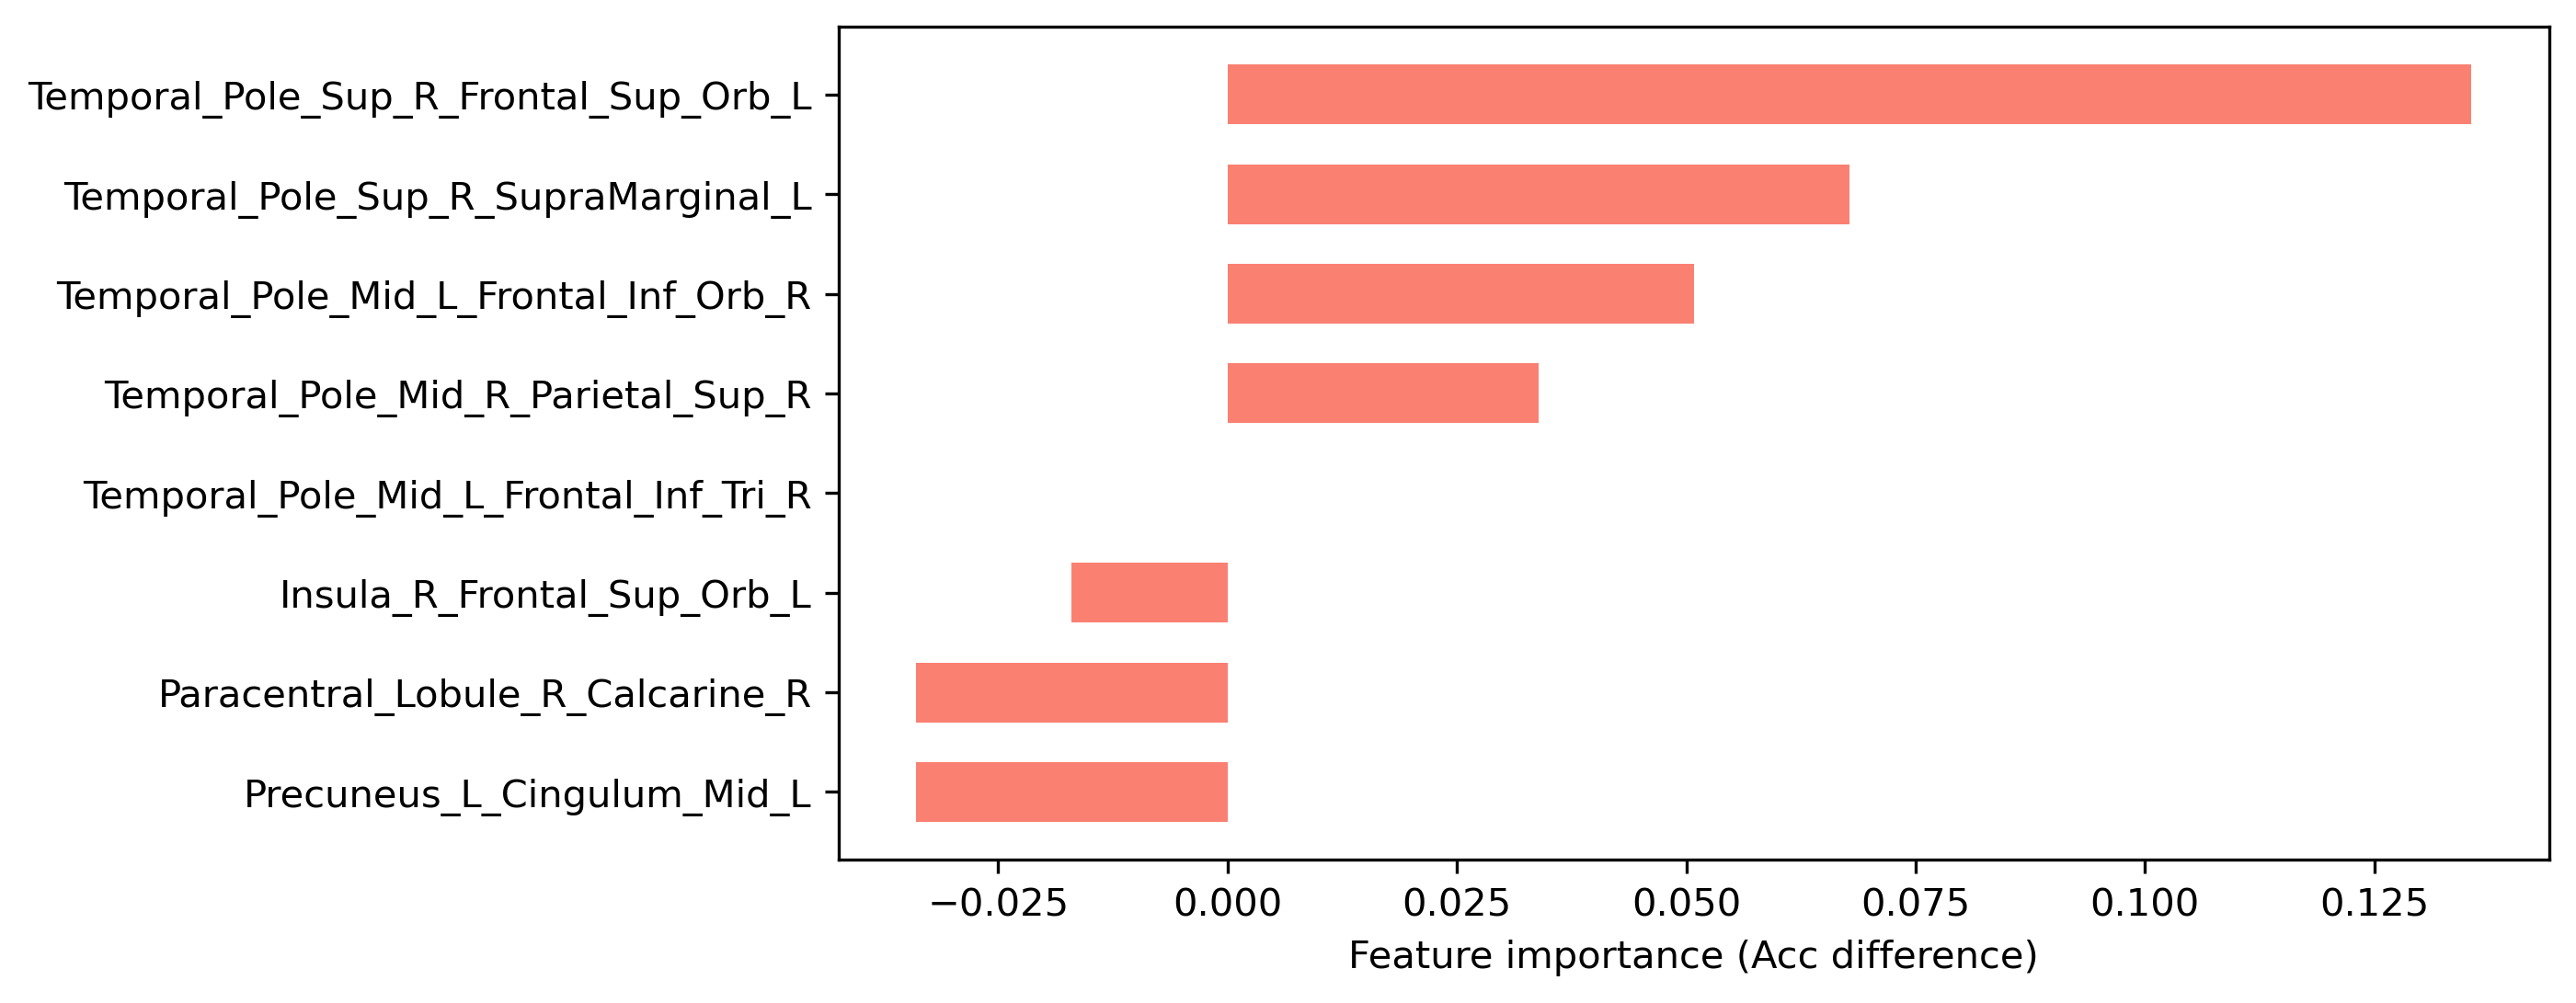

In [34]:
# 根据acc的差距展示重要的FC
max_acc = 0.661
acc_difference = max_acc - np.array(all_acc) 

sorted_index = np.argsort(acc_difference)
sorted_p_difference = acc_difference[sorted_index]
sorted_featurename = selected_feature['task']['feature_name'][sorted_index]

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4),dpi=300)
plt.barh([1,2,3,4,5,6,7,8], sorted_p_difference, tick_label=sorted_featurename, color='salmon',height=0.6)
# plt.xlabel('p-value difference')
plt.xlabel('Feature importance (Acc difference)')

In [ ]:
feature_importace_data_10 = pd.DataFrame()
feature_importace_data_10['value'] = sorted_p_difference[-7:]
feature_importace_data_10['brain_region1'] = ['Paracentral_Lobule_L', 'Temporal_Pole_Sup_L', 
                        'Insula_L', 'Putamen_R', 'Thalamus_R', 'Caudate_R', 'Temporal_Pole_Mid_R']
feature_importace_data_10['brain_region2'] = [ 'Cingulum_Post_R', 'Angular_L', 
                        'Frontal_Mid_L', 'Frontal_Mid_Orb_R', 'Hippocampus_L', 'Frontal_Mid_Orb_R', 'Angular_L']
feature_importace_data_10.to_csv(result_path + '/' + 'feature_importace_data_acc_7.csv')

In [ ]:
sorted_p_difference[-10:], tick_label=sorted_featurename[-10:]

In [ ]:
#保留指定行
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import scipy.io as scio  # 用于读取matlab格式的数据
import copy
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Lasso, ElasticNet

scaler = StandardScaler()

# import data
dataset = scaler.fit_transform(selected_feature['rest']['feature'])
# dataset = selected_feature['rest']['feature']    
############################SVM#######################

# C：C-SVC的惩罚参数C
# kernel: linear, poly, rbf, sigmoid, precomputed
C = 1
clf = SVC(C=C, kernel='rbf', gamma='auto')

############################Permutation################
n_feature = dataset.shape[1]

all_feature_acc = []

all_acc = []
select_feature = 30
for iter_feature in range(select_feature):
    # delete one feature 
    iter_dataset = dataset.copy()
    # iter_dataset = np.delete(iter_dataset, sorted_index[0:1], axis=1)
    iter_dataset = iter_dataset[:,sorted_index[-iter_feature:]]
    ############################SVM+LOOVC################
    loo = LeaveOneOut()
    loo.get_n_splits(iter_dataset)
    predictlabel_list = []
    reallabel_list = []

    # 用留一法进行验证
    for train_index, test_index in loo.split(iter_dataset):
        # 分割训练集
        X_train, X_test = iter_dataset[train_index], iter_dataset[test_index]
        # 分割测试集
        Y_train, Y_test = label[np.array(train_index)], label[np.array(test_index)]
        # 拟合
        clf.fit(X_train, Y_train)
        # 储存训练结果
        predictlabel_list.append(list(clf.predict(X_test)))
        reallabel_list.append(list(Y_test))

    iter_accuracy = accuracy_score(reallabel_list,predictlabel_list)
    # print(iter_accuracy)
    all_acc.append(iter_accuracy)


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4),dpi=300)
plt.barh(range(len(all_acc[2:23])), all_acc[2:23], tick_label=np.arange(3,24,1))
plt.ylabel('selected feature num')
plt.xlabel('acc')
plt.xlim([0.6,0.75])

In [ ]:
#单次运行
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import scipy.io as scio  # 用于读取matlab格式的数据
import copy
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Lasso, ElasticNet

scaler = StandardScaler()

# import data
dataset = scaler.fit_transform(selected_feature['rest']['feature'])
# dataset = selected_feature['rest']['feature']    
############################SVM#######################

# C：C-SVC的惩罚参数C
# kernel: linear, poly, rbf, sigmoid, precomputed
C = 0.9
clf = SVC(C=C, kernel='rbf', gamma='auto')

############################Permutation################
n_feature = dataset.shape[1]

all_feature_acc = []

# delete one feature 
iter_dataset = dataset.copy()
# iter_dataset = np.delete(iter_dataset, sorted_index[0:1], axis=1)
iter_dataset = iter_dataset[:,sorted_index[-10:]]
############################SVM+LOOVC################
loo = LeaveOneOut()
loo.get_n_splits(iter_dataset)
predictlabel_list = []
reallabel_list = []

# 用留一法进行验证
for train_index, test_index in loo.split(iter_dataset):
    # 分割训练集
    X_train, X_test = iter_dataset[train_index], iter_dataset[test_index]
    # 分割测试集
    Y_train, Y_test = label[np.array(train_index)], label[np.array(test_index)]
    # 拟合
    clf.fit(X_train, Y_train)
    # 储存训练结果
    predictlabel_list.append(list(clf.predict(X_test)))
    reallabel_list.append(list(Y_test))

# for i in range(len(predictlabel_list)):
#     if predictlabel_list[i>0.5]:
#         predictlabel_list[i]=1
#     else:
#         predictlabel_list[i]=0
iter_accuracy = accuracy_score(reallabel_list,predictlabel_list)
print(iter_accuracy)


In [ ]:
iter_accuracy

In [ ]:
iter_dataset = dataset.copy()
iter_dataset = np.delete(iter_dataset, 3, axis=1)

In [ ]:
np.array(dataset).shape

In [ ]:
all_permutation_acc

In [ ]:
from statsmodels.discrete.discrete_model import Logit, Probit, MNLogit
import statsmodels.api as sm
label = np.hstack((np.ones((1, 30)), np.zeros((1, 29))))

x = all_data['rest'][:,3]
x = sm.add_constant(x)

logit = Logit(np.squeeze(label), x)
result=logit.fit()
print(result.summary())
result.pvalues[1]

In [ ]:
hm_shutdown(1800)